# botorch_functions

In [ ]:
import torch
from torch import Tensor
import torch.nn as nn
import math
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

from botorch.fit import fit_gpytorch_torch

from botorch.models import SingleTaskGP
from botorch.test_functions import Hartmann
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.generation import get_best_candidates, gen_candidates_torch
from botorch.optim import gen_batch_initial_conditions
from botorch.acquisition import qExpectedImprovement, qUpperConfidenceBound
from botorch.sampling import SobolQMCNormalSampler
import os
from typing import Any, Callable, Dict, List, NoReturn, Optional, Tuple, Type, Union
from botorch.acquisition.acquisition import AcquisitionFunction
from botorch.acquisition.objective import (
    IdentityMCObjective,
    MCAcquisitionObjective,
    PosteriorTransform,
)
from botorch.models.model import Model
from botorch.sampling.samplers import MCSampler, SobolQMCNormalSampler
from botorch.sampling import SobolQMCNormalSampler
from botorch.utils.transforms import (
    concatenate_pending_points,
    match_batch_shape,
    t_batch_mode_transform,
)
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from inspect import signature


import time
from typing import Any, Dict, List, NamedTuple, Optional, Tuple

import numpy as np
from gpytorch.mlls.marginal_log_likelihood import MarginalLogLikelihood
from torch import Tensor
from torch.optim.adam import Adam
from torch.optim.optimizer import Optimizer


def check_convergence(
    loss_trajectory: List[float],
    param_trajectory: Dict[str, List[Tensor]],
    options: Dict[str, Union[float, str]],
) -> bool:
    r"""Check convergence of optimization for pytorch optimizers.

    Right now this is just a dummy function and only checks for maxiter.

    Args:
        loss_trajectory: A list containing the loss value at each iteration.
        param_trajectory: A dictionary mapping each parameter name to a list of Tensors
            where the `i`th Tensor is the parameter value at iteration `i`.
        options: dictionary of options. Currently only "maxiter" is supported.

    Returns:
        A boolean indicating whether optimization has converged.
    """
    maxiter: int = options.get("maxiter", 50)
    # TODO: Be A LOT smarter about this
    # TODO: Make this work in batch mode (see parallel L-BFGS-P)
    if len(loss_trajectory) >= maxiter:
        return True
    else:
        return False
    
    
def _filter_kwargs(function: Callable, **kwargs: Any) -> Any:
    r"""Filter out kwargs that are not applicable for a given function.
    Return a copy of given kwargs dict with only the required kwargs."""
    return {k: v for k, v in kwargs.items() if k in signature(function).parameters}

def _get_extra_mll_args(
    mll: MarginalLogLikelihood
) -> Union[List[Tensor], List[List[Tensor]]]:
    r"""Obtain extra arguments for MarginalLogLikelihood objects.

    Get extra arguments (beyond the model output and training targets) required
    for the particular type of MarginalLogLikelihood for a forward pass.

    Args:
        mll: The MarginalLogLikelihood module.

    Returns:
        Extra arguments for the MarginalLogLikelihood.
    """
    if isinstance(mll, ExactMarginalLogLikelihood):
        return list(mll.model.train_inputs)
    elif isinstance(mll, SumMarginalLogLikelihood):
        return [list(x) for x in mll.model.train_inputs]
    elif isinstance(mll, VariationalELBO):
        return []
    else:
        raise ValueError("Do not know how to optimize MLL type.")



ParameterBounds = Dict[str, Tuple[Optional[float], Optional[float]]]


class OptimizationIteration(NamedTuple):
    itr: int
    fun: float
    time: float



def fit_gpytorch_torch(
    mll: MarginalLogLikelihood,
    bounds: Optional[ParameterBounds] = None,
    optimizer_cls: Optimizer = Adam,
    options: Optional[Dict[str, Any]] = None,
    track_iterations: bool = True,
) -> Tuple[MarginalLogLikelihood, List[OptimizationIteration]]:
    r"""Fit a gpytorch model by maximizing MLL with a torch optimizer.

    The model and likelihood in mll must already be in train mode.
    Note: this method requires that the model has `train_inputs` and `train_targets`.

    Args:
        mll: MarginalLogLikelihood to be maximized.
        bounds: A ParameterBounds dictionary mapping parameter names to tuples
            of lower and upper bounds. Bounds specified here take precedence
            over bounds on the same parameters specified in the constraints
            registered with the module.
        optimizer_cls: Torch optimizer to use. Must not require a closure.
        options: options for model fitting. Relevant options will be passed to
            the `optimizer_cls`. Additionally, options can include: "disp"
            to specify whether to display model fitting diagnostics and "maxiter"
            to specify the maximum number of iterations.
        track_iterations: Track the function values and wall time for each
            iteration.

    Returns:
        2-element tuple containing

        - mll with parameters optimized in-place.
        - List of OptimizationIteration objects with information on each
          iteration. If track_iterations is False, this will be an empty list.

    Example:
        >>> gp = SingleTaskGP(train_X, train_Y)
        >>> mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        >>> mll.train()
        >>> fit_gpytorch_torch(mll)
        >>> mll.eval()
    """
    optim_options = {"maxiter": 100, "disp": True, "lr": 0.05}
    optim_options.update(options or {})
    optimizer = optimizer_cls(
        params=[{"params": mll.parameters()}],
        **_filter_kwargs(optimizer_cls, **optim_options),
    )

    # get bounds specified in model (if any)
    bounds_: ParameterBounds = {}
    if hasattr(mll, "named_parameters_and_constraints"):
        for param_name, _, constraint in mll.named_parameters_and_constraints():
            if constraint is not None and not constraint.enforced:
                bounds_[param_name] = constraint.lower_bound, constraint.upper_bound

    # update with user-supplied bounds (overwrites if already exists)
    if bounds is not None:
        bounds_.update(bounds)

    iterations = []
    t1 = time.time()

    param_trajectory: Dict[str, List[Tensor]] = {
        name: [] for name, param in mll.named_parameters()
    }
    loss_trajectory: List[float] = []
    i = 0
    converged = False
    train_inputs, train_targets = mll.model.train_inputs, mll.model.train_targets
    while not converged:
        optimizer.zero_grad()
        output = mll.model(*train_inputs)

        # we sum here to support batch mode
        args = [output, train_targets] + _get_extra_mll_args(mll)
        loss = -mll(*args).sum()
        loss.backward()
        loss_trajectory.append(loss.item())
        for name, param in mll.named_parameters():
            param_trajectory[name].append(param.detach().clone())
        if optim_options["disp"] and (
            (i + 1) % 10 == 0 or i == (optim_options["maxiter"] - 1)
        ):
            print(f"Iter {i + 1}/{optim_options['maxiter']}: {loss.item()}")
        if track_iterations:
            iterations.append(OptimizationIteration(i, loss.item(), time.time() - t1))
        optimizer.step()
        # project onto bounds:
        if bounds_:
            for pname, param in mll.named_parameters():
                if pname in bounds_:
                    param.data = param.data.clamp(*bounds_[pname])
        i += 1
        converged = check_convergence(
            loss_trajectory=loss_trajectory,
            param_trajectory=param_trajectory,
            options={"maxiter": optim_options["maxiter"]},
        )
    return mll, iterations






def clamp_tensor(tensor: torch.Tensor, bounds: torch.Tensor) -> torch.Tensor:
    """
    Clamps the values of a tensor within given bounds.

    Args:
        tensor (Tensor): The tensor to clamp.
        bounds (Tensor): A tensor containing the lower and upper bounds.

    Returns:
        Tensor: The clamped tensor.
    """
    if bounds.dim() == 2 and bounds.size(0) == 2:
        # Common bounds for all samples: bounds shape is (2, dim)
        lower_bounds, upper_bounds = bounds
    elif bounds.dim() == 3 and bounds.size(1) == 2:
        # Per-sample bounds: bounds shape is (batch_size, 2, dim)
        lower_bounds = bounds[:, 0, :]
        upper_bounds = bounds[:, 1, :]
    else:
        raise ValueError("Invalid bounds dimension. Expected bounds of shape (2, dim) or (batch_size, 2, dim).")
    
    # Perform clamping
    return torch.max(torch.min(tensor, upper_bounds), lower_bounds)

In [ ]:


def generate_initial_candidates(bounds: torch.Tensor, num_candidates: int) -> torch.Tensor:
    """
    Generates initial candidate points uniformly within the given bounds.

    Args:
        bounds (Tensor): A tensor containing the lower and upper bounds.
            - If bounds has shape (2, dim), it represents common bounds for all samples.
            - If bounds has shape (batch_size, 2, dim), it represents per-sample bounds.
        num_candidates (int): The number of candidates to generate.
            - For per-sample bounds, num_candidates must equal batch_size.

    Returns:
        Tensor: A tensor of initial candidate points with shape (num_candidates, dim).
    """
    
    
    if bounds.dim() == 2 and bounds.size(0) == 2:
        # Common bounds for all samples
        dim = bounds.shape[1]
        lower_bounds, upper_bounds = bounds  # Shapes: (dim,)
        # Generate random points uniformly within bounds
        random_numbers = torch.rand(num_candidates, dim)
        initial_points = lower_bounds + (upper_bounds - lower_bounds) * random_numbers
    elif bounds.dim() == 3 and bounds.size(1) == 2:
        # Per-sample bounds
        batch_size = bounds.shape[0]
        dim = bounds.shape[2]
        if num_candidates != batch_size:
            raise ValueError("For per-sample bounds, num_candidates must equal batch_size.")
        lower_bounds = bounds[:, 0, :]  # Shape: (batch_size, dim)
        upper_bounds = bounds[:, 1, :]  # Shape: (batch_size, dim)
        # Generate random points uniformly within per-sample bounds
        random_numbers = torch.rand(num_candidates, dim)
        initial_points = lower_bounds + (upper_bounds - lower_bounds) * random_numbers
    else:
        raise ValueError("Invalid bounds shape. Expected shape (2, dim) or (batch_size, 2, dim).")
    return initial_points


In [ ]:
def optimize_acquisition_function(
    acquisition_function: AcquisitionFunction,
    bounds: Tensor,
    num_restarts: int,
    raw_samples: int,
    num_candidates: int,
    optimizer_options: Optional[Dict[str, Any]] = None,
) -> Tensor:
    """
    Optimizes the acquisition function to find the next set of candidates.

    Args:
        acquisition_function (AcquisitionFunction): The acquisition function to optimize.
        bounds (Tensor): A tensor containing the lower and upper bounds.
        num_restarts (int): Number of restarts for optimization.
        raw_samples (int): Number of raw samples to use for initialization.
        num_candidates (int): Number of candidates to generate.
        optimizer_options (Optional[Dict[str, Any]]): Options for the optimizer.

    Returns:
        Tensor: The optimized candidate points.
    """
    from botorch.optim.optimize import optimize_acqf

    # Use BoTorch's built-in optimizer for acquisition functions
    # https://botorch.org/api/optim.html
    candidates, _ = optimize_acqf(
        acq_function=acquisition_function,
        bounds=bounds,
        q=num_candidates,
        num_restarts=num_restarts,
        raw_samples=raw_samples,
        options=optimizer_options or {},
    )
    return candidates


In [ ]:
def optimize_acquisition_function(
    acquisition_function: AcquisitionFunction,
    bounds: Tensor,
    num_restarts: int,
    raw_samples: int,
    num_candidates: int,
    optimizer_options: Optional[Dict[str, Any]] = None,
) -> Tensor:
    """
    Optimizes the acquisition function to find the next set of candidates.

    Args:
        acquisition_function (AcquisitionFunction): The acquisition function to optimize.
        bounds (Tensor): A tensor containing the lower and upper bounds.
        num_restarts (int): Number of restarts for optimization.
        raw_samples (int): Number of raw samples to use for initialization.
        num_candidates (int): Number of candidates to generate.
        optimizer_options (Optional[Dict[str, Any]]): Options for the optimizer.

    Returns:
        Tensor: The optimized candidate points.
    """
    from botorch.optim.optimize import optimize_acqf

    # Use BoTorch's built-in optimizer for acquisition functions
    candidates, _ = optimize_acqf(
        acq_function=acquisition_function,
        bounds=bounds,
        q=num_candidates,
        num_restarts=num_restarts,
        raw_samples=raw_samples,
        options=optimizer_options or {},
    )
    return candidates


In [ ]:


def one_step_bayesian_optimization(
    train_x: Tensor,
    train_y: Tensor,
    bounds: Tensor,
    num_candidates: int,
    acquisition_function_type: str = 'EI',
    acq_function_kwargs: Optional[Dict[str, Any]] = None,
    optimizer_options: Optional[Dict[str, Any]] = None,
) -> Tensor:
    """
    Performs one step of Bayesian Optimization to propose new candidate points.

    Args:
        train_x (Tensor): Training input data.
        train_y (Tensor): Training target data.
        bounds (Tensor): A tensor containing the lower and upper bounds.
        num_candidates (int): Number of candidates to propose.
        acquisition_function_type (str): Type of acquisition function ('EI' or 'UCB').
        acq_function_kwargs (Optional[Dict[str, Any]]): Additional arguments for the acquisition function.
        optimizer_options (Optional[Dict[str, Any]]): Options for the optimizer.

    Returns:
        Tensor: The proposed candidate points.
    """
    # Fit a Gaussian Process model
    model = SingleTaskGP(train_x, train_y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    

    
    fit_gpytorch_torch(mll)

    # Define the acquisition function
    if acquisition_function_type == 'EI':
        acq_func = qExpectedImprovement(
            model=model,
            best_f=train_y.max(),
            sampler=SobolQMCNormalSampler(sample_shape=torch.Size([500])),
            **(acq_function_kwargs or {})
        )
    elif acquisition_function_type == 'UCB':
        acq_func = qUpperConfidenceBound(
            model=model,
            beta=acq_function_kwargs.get('beta', 0.1),
            sampler=SobolQMCNormalSampler(sample_shape=torch.Size([500])),
        )
    else:
        raise ValueError("Unsupported acquisition function type.")

    # Optimize the acquisition function
    candidates = optimize_acquisition_function(
        acquisition_function=acq_func,
        bounds=bounds,
        num_restarts=10,
        raw_samples=100,
        num_candidates=num_candidates,
        optimizer_options=optimizer_options,
    )
    return candidates


In [ ]:
class CustomExpectedImprovement(MCAcquisitionFunction):
    def __init__(
        self,
        model: Model,
        best_f: Union[float, Tensor],
        xi: float = 0.0,
        sampler: Optional[MCSampler] = None,
        objective: Optional[MCAcquisitionObjective] = None,
        posterior_transform: Optional[PosteriorTransform] = None,
    ) -> None:
        super().__init__(
            model=model,
            sampler=sampler or SobolQMCNormalSampler(sample_shape=torch.Size([500])),
            objective=objective,
            posterior_transform=posterior_transform,
        )
        self.best_f = best_f
        self.xi = xi

    @concatenate_pending_points
    @t_batch_mode_transform()
    def forward(self, X: Tensor) -> Tensor:
        posterior = self.model.posterior(X)
        samples = self.sampler(posterior)
        obj = self.objective(samples) if self.objective else samples
        improvement = obj - self.best_f - self.xi
        return improvement.clamp_min(0).mean(dim=0)


In [ ]:
class CustomUpperConfidenceBound(MCAcquisitionFunction):
    def __init__(
        self,
        model: Model,
        beta: float = 0.1,
        sampler: Optional[MCSampler] = None,
        objective: Optional[MCAcquisitionObjective] = None,
        posterior_transform: Optional[PosteriorTransform] = None,
    ) -> None:
        super().__init__(
            model=model,
            sampler=sampler or SobolQMCNormalSampler(sample_shape=torch.Size([500])),
            objective=objective,
            posterior_transform=posterior_transform,
        )
        self.beta = beta

    @concatenate_pending_points
    @t_batch_mode_transform()
    def forward(self, X: Tensor) -> Tensor:
        posterior = self.model.posterior(X)
        samples = self.sampler(posterior)
        obj = self.objective(samples) if self.objective else samples
        mean = obj.mean(dim=0)
        std_dev = obj.std(dim=0)
        return mean + self.beta * std_dev


# botorch_fit

In [ ]:
# botorch_fit.py

import time
from typing import Optional, Dict, Any, List, NamedTuple, Tuple
import torch
from torch.optim import Optimizer, Adam
from gpytorch.mlls.marginal_log_likelihood import MarginalLogLikelihood
from gpytorch import settings as gpt_settings

class OptimizationIteration(NamedTuple):
    iteration: int
    loss: float
    wall_time: float

def fit_gpytorch_torch(
    mll: MarginalLogLikelihood,
    optimizer_cls: Optimizer = Adam,
    options: Optional[Dict[str, Any]] = None,
    track_iterations: bool = True,
    approx_mll: bool = True,
) -> Tuple[MarginalLogLikelihood, List[OptimizationIteration]]:
    """
    Fits a GPyTorch model by maximizing the Marginal Log Likelihood (MLL) using a PyTorch optimizer.

    Args:
        mll (MarginalLogLikelihood): The MLL to be maximized.
        optimizer_cls (Optimizer): The PyTorch optimizer class to use (default is Adam).
        options (Optional[Dict[str, Any]]): Options for model fitting and the optimizer.
            Relevant options include:
                - "lr": Learning rate for the optimizer.
                - "maxiter": Maximum number of iterations.
                - "disp": If True, displays optimization progress.
        track_iterations (bool): If True, tracks the function values and wall time for each iteration.
        approx_mll (bool): If True, uses approximate MLL computation for efficiency.

    Returns:
        Tuple containing:
            - mll: The MLL with optimized parameters.
            - iterations: A list of OptimizationIteration objects with information on each iteration.
    """
    options = options or {}
    lr = options.get("lr", 0.1)
    maxiter = options.get("maxiter", 50)
    disp = options.get("disp", False)
    exclude = options.get("exclude", None)

    # Prepare parameters for optimization
    if exclude is not None:
        mll_params = [
            t for p_name, t in mll.named_parameters() if p_name not in exclude
        ]
    else:
        mll_params = list(mll.parameters())

    optimizer = optimizer_cls(
        params=[{"params": mll_params}],
        lr=lr,
    )

    iterations = []
    t_start = time.time()
    param_trajectory: Dict[str, List[torch.Tensor]] = {
        name: [] for name, param in mll.named_parameters()
    }
    loss_trajectory: List[float] = []

    mll.train()
    train_inputs = mll.model.train_inputs
    train_targets = mll.model.train_targets

    for i in range(maxiter):
        optimizer.zero_grad()
        with gpt_settings.fast_computations(log_prob=approx_mll):
            output = mll.model(*train_inputs)
            # Sum over batch dimensions for compatibility
            loss = -mll(output, train_targets).sum()
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        loss_trajectory.append(loss_value)
        for name, param in mll.named_parameters():
            param_trajectory[name].append(param.detach().clone())

        if disp and ((i + 1) % 10 == 0 or i == maxiter - 1):
            print(f"Iter {i + 1}/{maxiter}: Loss = {loss_value:.4f}")

        if track_iterations:
            iterations.append(
                OptimizationIteration(
                    iteration=i,
                    loss=loss_value,
                    wall_time=time.time() - t_start,
                )
            )

    mll.eval()
    return mll, iterations, param_trajectory


In [ ]:
import torch
import numpy as np
import pandas as pd

# Define simulation parameters
num_frames = 100  # Number of frames in the video sequence
num_pedestrians = 5  # Number of unique pedestrians

# Generate mock data
frame_numbers = np.repeat(np.arange(1, num_frames + 1), num_pedestrians)
pedestrian_ids = np.tile(np.arange(1, num_pedestrians + 1), num_frames)
x_coordinates = np.random.uniform(0, 10, size=num_frames * num_pedestrians)  # Random X coordinates
y_coordinates = np.random.uniform(0, 10, size=num_frames * num_pedestrians)  # Random Y coordinates

# Create DataFrame
pedestrian_data = pd.DataFrame({
    "Frame Number": frame_numbers,
    "Pedestrian ID": pedestrian_ids,
    "X-Coordinate": x_coordinates,
    "Y-Coordinate": y_coordinates
})



pedestrian_data.head()

# Now set up for testing Bayesian optimization on this data
# Convert X and Y coordinates as sample input data for optimization function

# Convert data to PyTorch tensors for testing
train_x = torch.tensor(np.column_stack((x_coordinates, y_coordinates)), dtype=torch.float32)  # Mock input data
train_y = torch.sin(train_x[:, 0]) + torch.cos(train_x[:, 1])
 # Mock target values based on some function of X, Y

# Define bounds for optimization - based on the X and Y ranges in the dataset
bounds = torch.tensor([
    [train_x[:, 0].min(), train_x[:, 1].min()],
    [train_x[:, 0].max(), train_x[:, 1].max()]
])

# Function to simulate Bayesian Optimization step using provided code
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qExpectedImprovement
from botorch.sampling import SobolQMCNormalSampler
import gpytorch
    # Fit a Gaussian Process model
from botorch.models import SingleTaskGP
from gpytorch.likelihoods import GaussianLikelihood

def simulate_bayesian_optimization_step(train_x, train_y, bounds, num_candidates=2):


    likelihood = GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-5))
    model = SingleTaskGP(train_x, train_y.unsqueeze(-1), likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    
    
    
    
    with gpytorch.settings.cholesky_jitter(1e-1):
        fit_gpytorch_torch(mll)

    # Define Expected Improvement acquisition function
    from botorch.sampling import SobolQMCNormalSampler

    
    
    acq_func = qExpectedImprovement(
        model=model,
        best_f=train_y.max(),
        sampler=SobolQMCNormalSampler(num_samples=500),
    )


    # Optimize acquisition function to get candidate points
    from botorch.optim.optimize import optimize_acqf

    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=num_candidates,
        num_restarts=10,
        raw_samples=20,
    )
    return candidates

train_x = (train_x - train_x.mean(dim=0)) / train_x.std(dim=0)
train_y = (train_y - train_y.mean()) / train_y.std()

# Perform a single Bayesian Optimization step
candidates = simulate_bayesian_optimization_step(train_x, train_y, bounds)
candidates

tensor([[0.0107, 3.9043],
        [1.1047, 3.7779]])

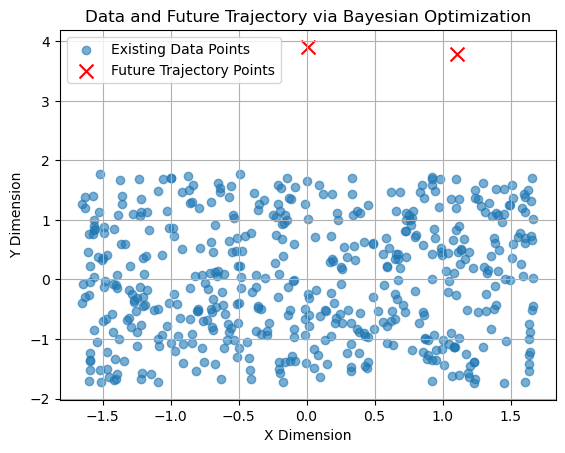

In [71]:
import matplotlib.pyplot as plt

# Assuming `train_x` contains your original data points and `candidates` holds the suggested future points.

# Convert tensors to NumPy arrays for plotting
train_x_np = train_x.numpy()
candidates_np = candidates.numpy()

# Plot the existing data points
plt.scatter(train_x_np[:, 0], train_x_np[:, 1], label='Existing Data Points', alpha=0.6)

# Plot the future trajectory (Bayesian Optimization candidates)
plt.scatter(candidates_np[:, 0], candidates_np[:, 1], color='red', marker='x', s=100, label='Future Trajectory Points')

# Adding labels and title
plt.xlabel('X Dimension')
plt.ylabel('Y Dimension')
plt.title('Data and Future Trajectory via Bayesian Optimization')
plt.legend()
plt.grid(True)
plt.show()
